In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, BatchNormalization, ReLU, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet
import os
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True



2023-03-10 19:12:39.022644: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-10 19:12:39.115674: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-10 19:12:39.117864: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-10 19:12:39.117873: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
## Get Mobile

In [3]:
# Load the pre-trained MobileNet V1 model for 64x64x1 input
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Add a new output layer with sigmoid activation for binary classification
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Create the new model
model = tf.keras.models.Model(inputs=base_model.input, outputs=x)

model.summary()



2023-03-10 19:12:40.199718: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-10 19:12:40.199872: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-10 19:12:40.199902: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-03-10 19:12:40.199925: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-03-10 19:12:40.199949: W tensorflow/c

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32)       128       
 ation)                                                      

### Prepare custom implementation, lighter than MobileNetV1

In [4]:
# Define input shape
S1 = S2 = 128
input_shape = (S1, S2, 1)

# Define input layer
inputs = Input(shape=input_shape)

# Define convolutional layers
x = Conv2D(32, (3, 3), strides=(2, 2), padding='same')(inputs)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D((3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(64, (1, 1), strides=(1, 1), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D((3, 3), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(128, (1, 1), strides=(1, 1), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D((3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(128, (1, 1), strides=(1, 1), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D((3, 3), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(256, (1, 1), strides=(1, 1), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D((3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(256, (1, 1), strides=(1, 1), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D((3, 3), strides=(2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(512, (1, 1), strides=(1, 1), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

x = DepthwiseConv2D((3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)
x = Conv2D(512, (1, 1), strides=(1, 1), padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

# Define output layers
x = GlobalAveragePooling2D()(x)
outputs = Dense(1, activation='sigmoid')(x)

# Create the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 64, 64, 32)        0         
                                                                 
 depthwise_conv2d (Depthwise  (None, 64, 64, 32)       320       
 Conv2D)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 32)       128 

In [5]:
DATA_ROOT_FOLDER = "/media/edge7/TOSHIBA EXT/"  # Modify this as needed, you should have this variable set in get_dataset.ipynb, use the same
DATA_IS_IN = os.path.join(DATA_ROOT_FOLDER, 'data') # Don't modify this

In [6]:
PERSON_FILES = list(os.listdir(os.path.join(DATA_IS_IN, 'person')))
random.shuffle(PERSON_FILES)
NO_PERSON_FILES = list(os.listdir(os.path.join(DATA_IS_IN, 'notperson')))
random.shuffle(NO_PERSON_FILES)
FOR_TRAIN_PERSON = int(0.9 * len(PERSON_FILES))
FOR_TRAIN_NO_PERSON = int(0.9 * len(NO_PERSON_FILES))

In [7]:
all_files_train_p = [os.path.join( DATA_IS_IN, 'person', x) for x in PERSON_FILES[0:FOR_TRAIN_PERSON]]
all_files_train_np = [os.path.join( DATA_IS_IN, 'notperson', x) for x in NO_PERSON_FILES[0:FOR_TRAIN_NO_PERSON]]
all_files_test_p = [os.path.join( DATA_IS_IN, 'person', x) for x in PERSON_FILES[FOR_TRAIN_PERSON:]]
all_files_test_np = [os.path.join( DATA_IS_IN, 'notperson', x) for x in NO_PERSON_FILES[FOR_TRAIN_NO_PERSON:]]

In [8]:
print(f"#Total files  {len(PERSON_FILES) + len(NO_PERSON_FILES)}")
print(f"#Total files with people in it {len(PERSON_FILES)}")
print(f"#Total files with NO people in it {len(NO_PERSON_FILES)}")
print(f"#Total files with people in it just for TRAINING {len(all_files_train_p)}")
print(f"#Total files with NO people in it just for TRAINING {len(all_files_train_np)}")
print(f"#Total files with people in it just for TESTING {len(all_files_test_p)}")
print(f"#Total files with NO people in it just for TESTING {len(all_files_test_np)}")

#Total files  11000
#Total files with people in it 5500
#Total files with NO people in it 5500
#Total files with people in it just for TRAINING 4950
#Total files with NO people in it just for TRAINING 4950
#Total files with people in it just for TESTING 550
#Total files with NO people in it just for TESTING 550


In [9]:
all_files_train = {'person': all_files_train_p, 'noperson': all_files_train_np}
all_files_test = {'person': all_files_test_p, 'noperson': all_files_test_np}


In [10]:
### Augmentation functions

In [11]:
def bright(img):
    import random
    max_delta = 0.4 # it gets random between -max_delta, +max_delta
    seed = random.uniform(0, 100)
    seed = int(seed)
    seed = seed, seed
    return tf.image.stateless_random_brightness(img, max_delta, seed=seed)

def contrast(img):
    import random
    min_ = 0.2
    max_ = 2.5
    seed = random.uniform(0, 100)
    seed = int(seed)
    seed = seed, seed
    return tf.image.stateless_random_contrast(img, min_, max_, seed=seed)

def gamma(img):
    import random

    gamma = random.uniform(1, 10)
    gain = random.uniform(1, 10)

    return tf.image.adjust_gamma(
        img, gamma=gamma, gain=gain
    )

def noise(img):
    import random
    seed = random.uniform(0, 100)
    seed = int(seed)
    seed = seed, seed
    return tf.image.stateless_random_jpeg_quality(
        img, 10, 90, seed=seed)

def saturation(img):
    import random
    seed = random.uniform(0, 100)
    seed = int(seed)
    seed = seed, seed
    return tf.image.stateless_random_saturation(img, 0.1, 2, seed=seed)

def identity(img):
    return img


funcs = [lambda x: bright(x), lambda x: contrast(x), lambda x: gamma(x), lambda x: noise(x), lambda x: noise(x), lambda x: saturation(x), lambda x: identity(x)]

def get_augmentation_func(functions):
    from random import shuffle
    shuffle(functions)
    return functions[0]

In [12]:
import random
def image_generator(files, batch_size = 32, sz=(S1, S2), it_is_test=False):

    for attempt in range(5):

        try:
            #extract a random batch
            batch = [ (1, x) for x in np.random.choice(files['person'], size = int(batch_size / 2))] + \
                    [ (0, x) for x in np.random.choice(files['noperson'], size = int(batch_size / 2))]

            #variables for collecting batches of inputs and outputs
            batch_x = []
            batch_y = []

            for category, path in batch:
                thres = 0.85
                image = Image.open(path)
                image = np.array(image.resize(sz, resample=Image.BILINEAR))
                if image.ndim == 3 and image.shape[2] == 4:
                    image = image[..., :3]  # Remove the alpha channel

                if len(image.shape) == 3 and random.random() < thres and not it_is_test:
                    # Apply augmentation
                    aug_func = get_augmentation_func(funcs)
                    for _ in range(int(random.uniform(1, 3))):
                        image = aug_func(image)
                        image = np.array(image)

                if image.ndim == 3:
                    image = np.dot(image[...,:3], [0.2989, 0.5870, 0.1140]) # To gray scale
                batch_x.append(image)
                batch_y.append(int(category))


            # normalize a batch of images
            batch_x = np.array(batch_x)/256

            return [batch_x, batch_y]

        except Exception as e:
            print("ERROR", str(e), path)
            print("Will try again ", attempt)

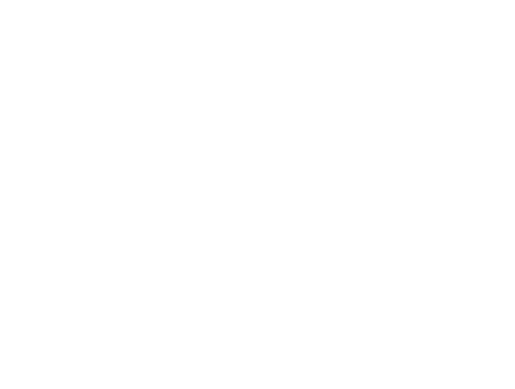

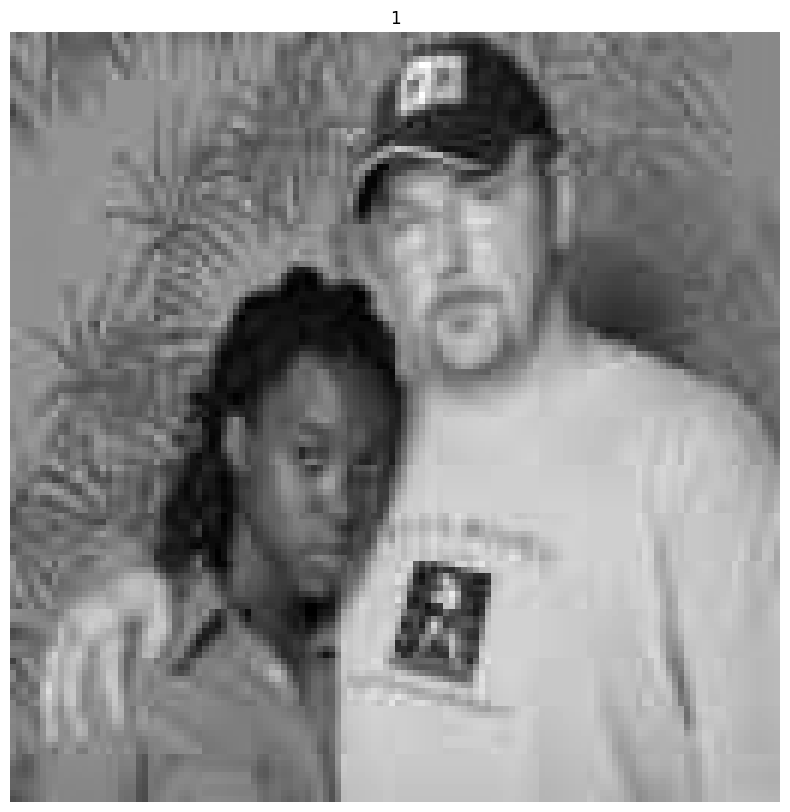

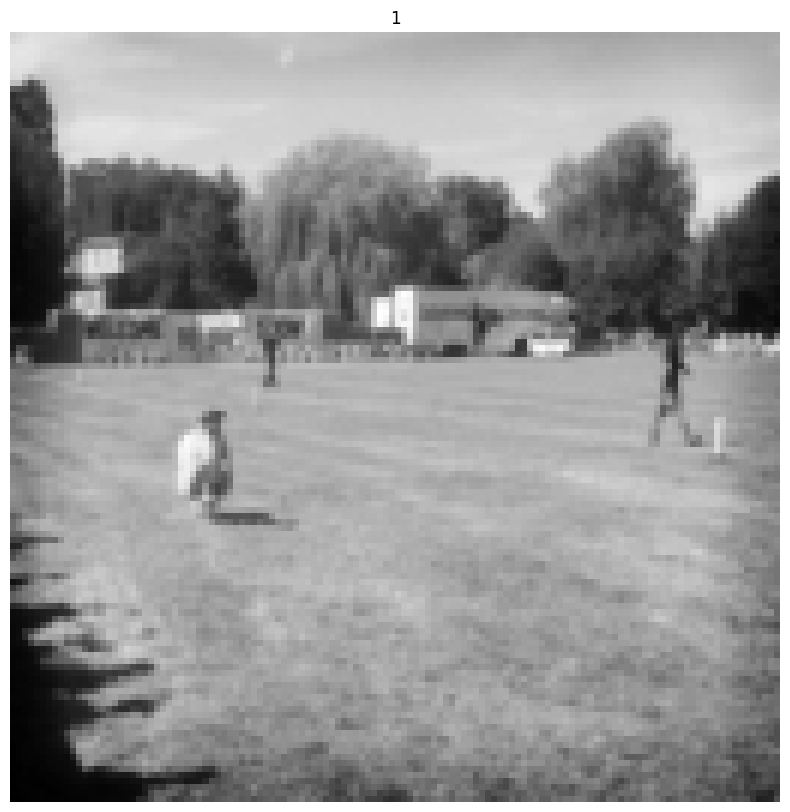

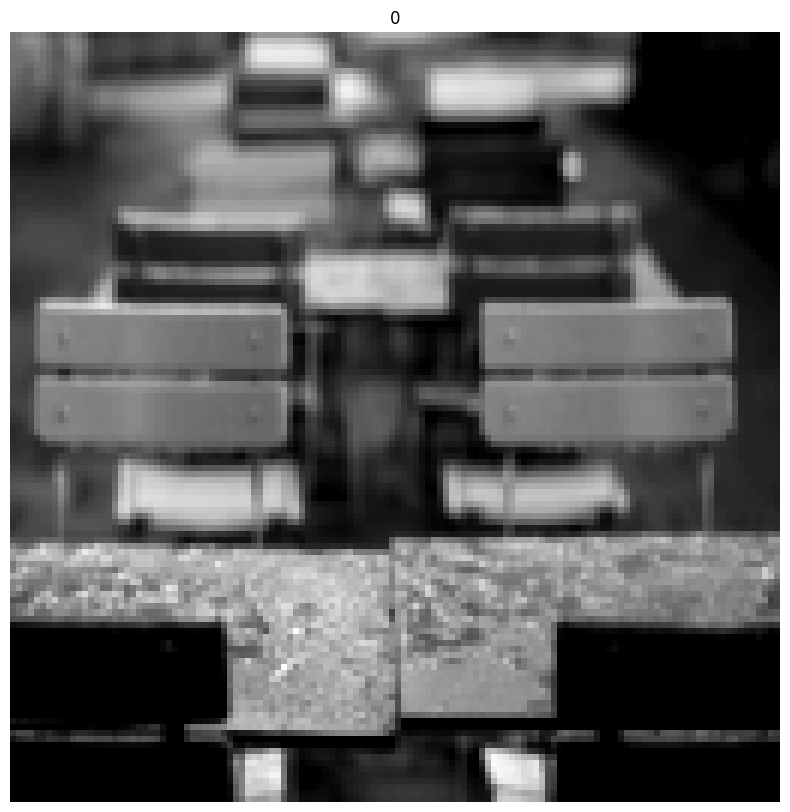

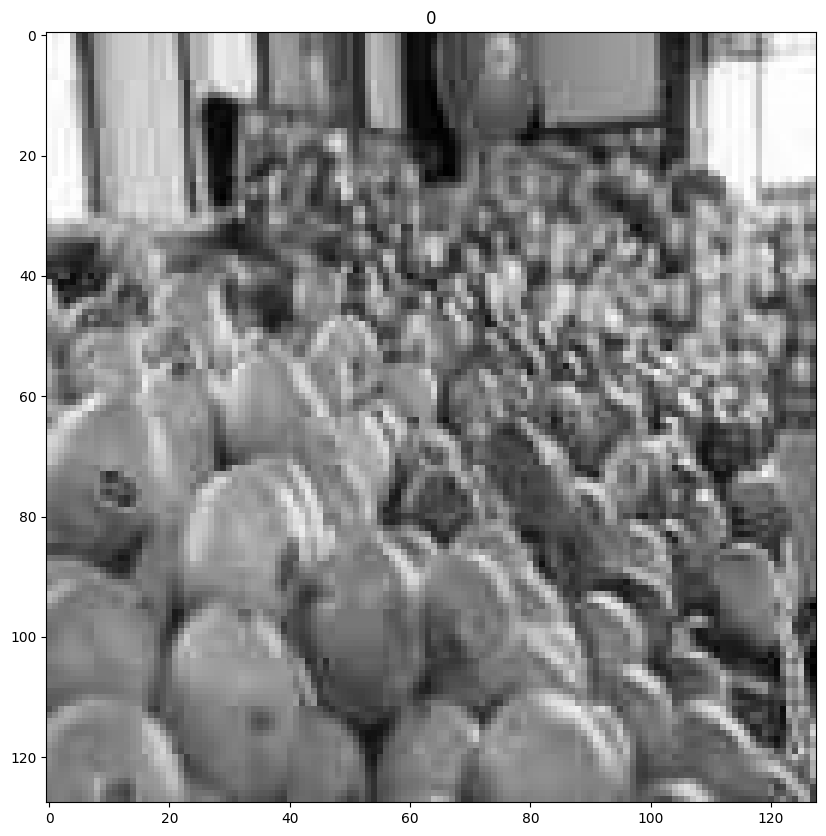

In [13]:
chunk = image_generator(all_files_train, batch_size = 5, it_is_test=False)
for x, y in zip(chunk[0], chunk[1]):
    plt.axis('off')
    img = x
    plt.figure(figsize = (10, 10))
    plt.title(str(y))
    plt.imshow( x, cmap='gray')

### Define function for training

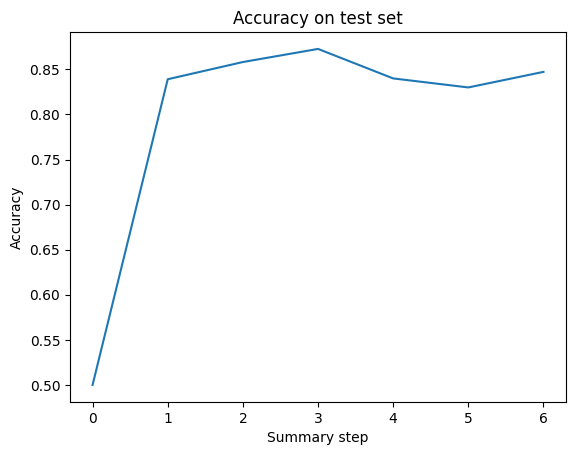

 97%|█████████▋| 30001/30900 [3:23:54<52:02,  3.47s/it]

Total number of steps: 30900, writing summary every 309 steps


100%|██████████| 30900/30900 [3:29:57<00:00,  2.45it/s]


In [18]:
from tqdm import tqdm
from IPython.display import clear_output

SUMMARIZE_EACH = 5000
def train(model_to_train, n_epochs=100, n_batch=32):

    # calculate the number of batches per training epoch
    bat_per_epo = int((len(all_files_train_p) + len(all_files_train_np)) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs

    accuracies = []
    print("Total number of steps: %d, writing summary every %d steps" % (n_steps, bat_per_epo))
    # manually enumerate epochs
    for i in tqdm(range(n_steps)):
        x, y_real = image_generator(all_files_train, batch_size=n_batch, sz=(S1, S2), it_is_test=False)
        model_to_train.train_on_batch(x ,  np.array(y_real).reshape((-1, 1)))
        if i % SUMMARIZE_EACH == 0:
            print("testing")
            x, y_real_test = image_generator(all_files_test, batch_size = len(all_files_test_p) + len(all_files_test_np), it_is_test=True)
            predictions_on_test = model.predict(x)
            accuracy_metric = tf.keras.metrics.BinaryAccuracy()
            accuracy_metric.update_state(y_real_test, predictions_on_test)
            accuracy = accuracy_metric.result().numpy()
            print("Accuracy on test", accuracy)
            to_save = False

            accuracies.append(accuracy)
            if accuracy >= max(accuracies):
                to_save = True
            # Plot the accuracies
            # Plot the accuracies
            clear_output(wait=True)  # Clear the output area
            plt.plot(accuracies)
            plt.title('Accuracy on test set')
            plt.xlabel('Summary step')
            plt.ylabel('Accuracy')
            plt.show()
            print("Total number of steps: %d, writing summary every %d steps" % (n_steps, bat_per_epo))
            if to_save:
                print("saving: ", accuracy)
                model.save("model.h5")



train(model)